In [1]:
import numpy as np
import pandas as pd
import random,operator
import multiprocessing
import itertools
#from joblib import Parallel, delayed
import math
from aco import ACO, Graph
from plot import plot
import sys

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def selection(topRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(topRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    for i in range(0, eliteSize):
        selectionResults.append(topRanked[i][0])
    for i in range(0, len(topRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(topRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(topRanked[i][0])
                break
    return selectionResults

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
def order1Crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    geneA,geneB = random.sample(range(0,len(parent1)), 2)
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]
    childP2[startGene:startGene] = childP1
    return childP2

In [10]:
def orderBasedCrossover(parent1,parent2):
    child1,child2 = parent1,parent2
    index_list = random.sample(range(0,len(parent1)), 5)
    index_list.sort()
    parent2_order  = [parent2[i] for i in index_list]
    k = 0
    for i in range(len(child1)):
        if child1[i] in parent2_order:
            child1[i] = parent2_order[k]
            k=k+1       
    return child1   

In [11]:
def pickBestpaths(pathstring,k):
    distance_list = []
    no_of_cities = len(pathstring)
    for i in range(len(pathstring)):
        xDis = abs(pathstring[i].x - pathstring[(i+1)%no_of_cities].x)
        yDis = abs(pathstring[i].y - pathstring[(i+1)%no_of_cities].y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        distance_list.append(distance)
    start_indices_top_k = np.argsort(distance_list).tolist()[0:k]
    full_indices_list = []
    for i in start_indices_top_k:
        full_indices_list.extend([i,(i+1)%no_of_cities])
    return full_indices_list    

In [12]:
def pickBestsequencepaths(pathstring):
    distance_list = []
    no_of_cities = len(pathstring)
    for i in range(len(pathstring)):
        xDis = abs(pathstring[i].x - pathstring[(i+1)%no_of_cities].x)
        yDis = abs(pathstring[i].y - pathstring[(i+1)%no_of_cities].y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        distance_list.append(distance)
    #distance_list = [3, 4, 2, -3, -1, 9, -5]    
    min_ending_here =  sys.float_info.max 
    min_so_far =  sys.float_info.max
    
    for i in range(len(distance_list)):  
        if (min_ending_here > 0): 
            min_ending_here = distance_list[i]   
            start_index = i
        else: 
            min_ending_here += distance_list[i] 
        
        if min_ending_here < min_so_far:
            min_so_far = min_ending_here
            min_end_index  = i
            min_start_index = start_index
    #print(min_start_index,min_end_index)
    return min_start_index,min_end_index

In [13]:
def bestpick_order1Crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    startGene,endGene = pickBestsequencepaths(parent1)
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]
    #print(childP1,childP2)
    childP2[startGene:startGene] = childP1
    return childP2

In [14]:
def bestpick_orderBasedCrossover(parent1,parent2):
    child1,child2 = parent1,parent2
    index_list = pickBestpaths(parent1,10)
    index_list.sort()
    #index_list = [1,2,5]
    #print(index_list)
    parent2_order  = [parent2[i] for i in set(index_list)]
    k = 0
    for i in range(len(child1)):
        if child1[i] in parent2_order:
            child1[i] = parent2_order[k]
            k=k+1       
    return child1   

In [15]:
def combinationCrossover(parent1,parent2):
    crossoverop = random.sample(list(crossover_function_dict.keys()),1)[0]
    child = crossoverop(parent1,parent2)
    return child

In [16]:
def breedPopulation(matingpool, eliteSize,crossoveroperator):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    #crossoveroperator 
    for i in range(0, length):
        child = crossoveroperator(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [17]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [18]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [19]:
def nextGeneration(currentGen, eliteSize, mutationRate,crossoverop):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize,crossoverop)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [20]:
def geneticAlgorithm(params):
    population, popSize, eliterate, mutationRate, generations, crossoverop = [params[i] for i in range(0,6)]
    pop = initialPopulation(popSize, population)
    initial_distance = 1 / rankRoutes(pop)[0][1]
    print("Initial distance: " + str(initial_distance))
    eliteSize=int(eliterate*popSize)
    min_distance,min_generation_num  = 999999,generations
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate,crossoverop)
        current_min_dist = 1 / rankRoutes(pop)[0][1]
        if current_min_dist < min_distance:
            min_distance = current_min_dist
            min_generation_num = i
    final_distance = 1 / rankRoutes(pop)[0][1]
    print("Final distance: " + str(final_distance))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    #solutions_df.loc[len(solutions_df)] = [popSize,eliteSize,mutationRate,generations,initial_distance,final_distance]
    #return [popSize,eliterate,mutationRate,generations,initial_distance,final_distance]
    if crossoverop == combinationCrossover :
        crossoverop_name = "Combination Crossover"
    else :    
        crossoverop_name = crossover_function_dict[crossoverop]
    return [str(crossoverop_name),popSize,eliterate,mutationRate,min_generation_num,initial_distance,min_distance,final_distance]

In [21]:
cityList = []
for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [22]:
population = [cityList]
population_size_list = [100,200]
elite_rate_list = [0.1,0.2,0.3]
mutation_rate_list = [0.001,0.1,0.01,0]
no_of_generations_list = [100,500]
'''population_size_list = [100]
elite_rate_list = [0.1]
mutation_rate_list = [0.001]
no_of_generations_list = [10]'''
crossover_function_dict = {bestpick_orderBasedCrossover:"bestpick_orderBasedCrossover",bestpick_order1Crossover:"bestpick_order1Crossover",orderBasedCrossover:"orderBasedCrossover",order1Crossover:"order1Crossover"}
crossover_functions_list = list(crossover_function_dict.keys())+[combinationCrossover]
paramlist = list(itertools.product(population,population_size_list,elite_rate_list,mutation_rate_list,no_of_generations_list,crossover_functions_list))
#solutions_df = pd.DataFrame(columns=['Population Size','Elite Size','Mutation Rate','No of Generations','Initial Distance','Final Distance'])
results = []
#geneticAlgorithm = TaskGenerator(geneticAlgorithm)
pool = multiprocessing.Pool()
results.append(pool.map(geneticAlgorithm,paramlist))
#print('result',results)
#solutions_df.loc[len(solutions_df)] = [popSize,eliteSize,mutationRate,generations,distances_returned[0],distances_returned[1]]
solutions_df = pd.DataFrame(np.array(results[0]), columns=['Crossover Operator','Population Size','Elite Rate','Mutation Rate','No of Generations','Initial Distance','Minimum Distance','Final Distance'])

Initial distance: 1648.2449916333221
Initial distance: 1687.7643374714548
Initial distance: 1754.0968705881555
Initial distance: 1781.059922977437
Initial distance: 1697.0767757574586
Initial distance: 1759.5024056991595
Initial distance: 1803.6288670023264
Initial distance: 1757.1208962567757
Initial distance: 1771.4043625085917
Initial distance: 1775.0361935297055
Initial distance: 1704.187298696139
Initial distance: 1609.9079893137769
Initial distance: 1692.8235359900004
Initial distance: 1666.8839632011204
Initial distance: 1667.0660561956786
Initial distance: 1753.471701225273
Final distance: 1941.232001635521
Initial distance: 1747.5866822914375
Final distance: 2221.5678594417723
Final distance: 998.2013072312228
Initial distance: 1792.140902826393
Initial distance: 1878.738635635314
Final distance: 2224.286718753474
Initial distance: 1721.8047480617042
Final distance: 1271.3914860092957
Initial distance: 1733.952317193312
Final distance: 1621.7864190422144
Final distance: 2178.4

Final distance: 1912.2020664972856
Initial distance: 1795.611674206363
Final distance: 955.2687273096403
Initial distance: 1695.8086297928726
Final distance: 1108.9742041125974
Initial distance: 1804.2972160923837
Final distance: 2262.3564597570744
Initial distance: 1767.5530299139807
Final distance: 2126.0677331382753
Initial distance: 1735.4671947044048
Final distance: 843.1565575487977
Initial distance: 1477.8913862553302
Final distance: 2225.213862302705
Initial distance: 1680.287697841295
Final distance: 1968.3615905974573
Initial distance: 1552.573750071042
Final distance: 1188.3327242713601
Initial distance: 1598.3416032845676
Final distance: 1767.5530299139807
Initial distance: 1616.6624455197853
Final distance: 1457.102324368706
Initial distance: 1720.8263143931385
Final distance: 2292.3984631053695
Initial distance: 1746.4262140565477
Final distance: 883.4932290012557
Initial distance: 1679.2467676628364
Final distance: 2045.7047467533025
Initial distance: 1737.674214037725
F

Final distance: 1739.2697490416726
Final distance: 908.283017083635
Final distance: 2332.884281647129
Initial distance: 1776.630581535882
Final distance: 902.4004859132407
Initial distance: 1761.8634788818295
Final distance: 2345.3529433766266
Final distance: 1776.630581535882
Final distance: 2378.3998569159344
Final distance: 1536.9511558317809
Initial distance: 1797.7770860345192
Final distance: 1979.4255334022532
Initial distance: 1614.243723114796
Final distance: 869.1390237908016
Final distance: 2121.2347721011556
Final distance: 1674.8121478751962
Final distance: 717.8756071255011
Initial distance: 1748.512513980125
Final distance: 859.6998316629972


In [23]:
solutions_df

,Crossover Operator,Population Size,Elite Rate,Mutation Rate,No of Generations,Initial Distance,Minimum Distance,Final Distance
0,bestpick_orderBasedCrossover,100,0.1,0.001,1,1757.1208962567757,1693.5957143708476,2049.993175977679
1,bestpick_order1Crossover,100,0.1,0.001,99,1713.3360143017392,1096.5189025533973,1096.5189025533973
2,orderBasedCrossover,100,0.1,0.001,0,1782.5244873495044,1737.2211699716363,2201.977988619393
3,order1Crossover,100,0.1,0.001,64,1693.9006647732585,795.6746709645504,795.6746709645504
4,Combination Crossover,100,0.1,0.001,96,1754.0968705881555,1240.163650764387,1271.3914860092957
5,bestpick_orderBasedCrossover,100,0.1,0.001,87,1733.952317193312,1654.9232176100406,1953.9021194574914
6,bestpick_order1Crossover,100,0.1,0.001,415,1884.9602172676593,904.4567798041056,904.4567798041056
7,orderBasedCrossover,100,0.1,0.001,16,1832.0466791372091,1579.3373188208018,2283.8200538978735
8,order1Crossover,100,0.1,0.001,371,1759.5024056991595,823.1773142935033,823.1773142935033
9,Combination Crossover,100,0.1,0.001,421,1656.9624182227628,952.3434277269516,974.4374109616504


In [24]:
solutions_df["Final Distance"] = solutions_df['Final Distance'].astype(float)
solutions_df["Minimum Distance"] = solutions_df['Minimum Distance'].astype(float)

In [25]:
solutions_df.describe()

,Minimum Distance,Final Distance
count,240.000000,240.000000
mean,1294.340711,1565.919846
std,352.945253,589.948976
min,692.754890,692.754890
25%,927.528385,933.357919
50%,1346.838043,1595.486618
75%,1627.477509,2126.829410
max,1804.297216,2626.897932


In [26]:
solutions_df.iloc[solutions_df[["Final Distance"]].idxmin()]


,Crossover Operator,Population Size,Elite Rate,Mutation Rate,No of Generations,Initial Distance,Minimum Distance,Final Distance
168,order1Crossover,200,0.2,0.001,156,1679.2467676628364,692.75489,692.75489


In [27]:
solutions_df.iloc[solutions_df[["Minimum Distance"]].idxmin()]

,Crossover Operator,Population Size,Elite Rate,Mutation Rate,No of Generations,Initial Distance,Minimum Distance,Final Distance
168,order1Crossover,200,0.2,0.001,156,1679.2467676628364,692.75489,692.75489


In [28]:
solutions_df[["Final Distance"]].min()

Final Distance    692.75489
dtype: float64

In [29]:
solutions_df

,Crossover Operator,Population Size,Elite Rate,Mutation Rate,No of Generations,Initial Distance,Minimum Distance,Final Distance
0,bestpick_orderBasedCrossover,100,0.1,0.001,1,1757.1208962567757,1693.595714,2049.993176
1,bestpick_order1Crossover,100,0.1,0.001,99,1713.3360143017392,1096.518903,1096.518903
2,orderBasedCrossover,100,0.1,0.001,0,1782.5244873495044,1737.221170,2201.977989
3,order1Crossover,100,0.1,0.001,64,1693.9006647732585,795.674671,795.674671
4,Combination Crossover,100,0.1,0.001,96,1754.0968705881555,1240.163651,1271.391486
5,bestpick_orderBasedCrossover,100,0.1,0.001,87,1733.952317193312,1654.923218,1953.902119
6,bestpick_order1Crossover,100,0.1,0.001,415,1884.9602172676593,904.456780,904.456780
7,orderBasedCrossover,100,0.1,0.001,16,1832.0466791372091,1579.337319,2283.820054
8,order1Crossover,100,0.1,0.001,371,1759.5024056991595,823.177314,823.177314
9,Combination Crossover,100,0.1,0.001,421,1656.9624182227628,952.343428,974.437411


##Ant colony optimization for tsp

In [30]:
def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

cost: 726.1996980756463, path: [5, 17, 20, 11, 24, 16, 14, 23, 18, 0, 4, 10, 13, 21, 15, 2, 3, 7, 6, 22, 19, 9, 12, 8, 1]


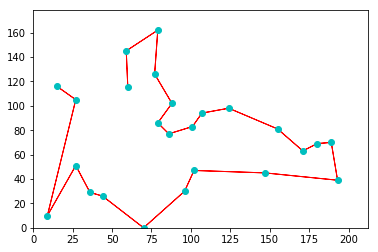

In [31]:
cities = []
points = []
index = 0 
for city  in cityList:
    cities.append(dict(index=int(index), x=city.x, y=city.y))
    points.append((city.x, city.y))
    index = index + 1
cost_matrix = []
rank = len(cities)
for i in range(rank):
        row = []
        for j in range(rank):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)
aco = ACO(10, 500, 1.0, 10.0, 0.5, 10, 2)
graph = Graph(cost_matrix, rank)
path, cost = aco.solve(graph)
print('cost: {}, path: {}'.format(cost, path))
plot(points, path)